In [92]:
import re
import random
import pandas as pd
import hashlib

In [93]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [94]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
GUI Docker Container,118.818443,5.658021,11.880264,21
Linux,192.963349,6.030105,23.007718,32
"Everything is Tuberculosis, Green",147.422162,6.409659,17.885934,23
WinHex,208.132000,9.911048,16.412640,21
Azure Compute Gallery,43.698294,21.849147,21.883156,2
"The Simulacra, Dick",505.327948,26.596208,55.415457,19
Windows PATH Variable,966.851566,32.228386,87.023077,30
Node.JS and React,1458.187613,47.038310,123.959369,31
pfSense,260.145275,52.029055,102.159433,5
"Mexican Gothic, Moreno-Garcia",1670.904852,59.675173,222.259705,28


# Histogram

sum of ages: ~49461.77


<Axes: >

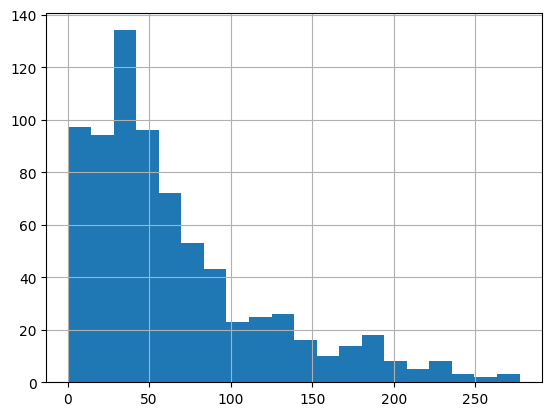

In [95]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49461.77


<Axes: >

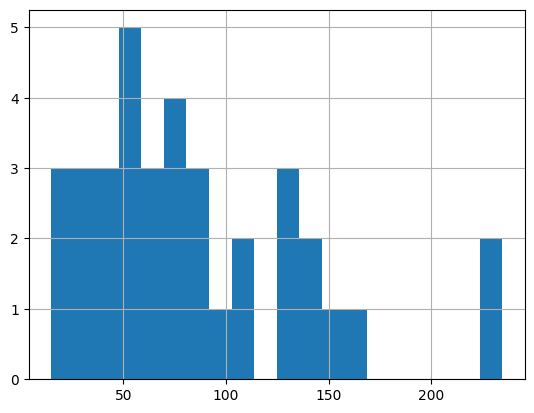

In [96]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Terraform Codebox']['age'].hist(bins=20)

# Completely Random Shuffle

In [97]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [98]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [99]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [100]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [101]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [102]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

modulo for n-fold
Cards found: 750
Total card age: 49461.77


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
58,Azure Compute Gallery,Azure Marketplace Image as a Base – Using a pr...,0d150bb03591ea0166f17b89e7412ee1,21.883156,21.849147,-21.883156,43.698294,0.363880,2,0,0,-21.883156
49,pfSense,OPT\nOPT or Optional interfaces refer to any a...,4abde57f8cc39259acb1aaa915667281,102.159433,52.029055,-102.159433,260.145275,0.102517,5,0,0,-102.159433
132,pfSense,The standard size IPv6 subnet defined by the I...,f8edfd22a36b84ded0b9ceae95b12df5,33.291205,52.029055,-102.159433,260.145275,0.102517,5,3,0,-33.291205
78,Vocab,"Something Rotten, Fforde\nBuddleia\nnoun | BUD...",52e112ba21a6244c085dd3602ad50fb5,179.316764,65.471916,-179.316764,720.191072,0.579205,11,0,0,-179.316764
158,Vocab,"Well of Lost Plots, Fforde\nThrombosis\nnoun |...",5143fdc2ff65269873e872f090074d49,57.107176,65.471916,-179.316764,720.191072,0.579205,11,3,0,-57.107176
236,Vocab,"Something Rotten, Fforde\nRusk\nnoun | RUSK\nA...",57368f2b4abd5cd69909da3cf00b13b8,46.666828,65.471916,-179.316764,720.191072,0.579205,11,6,0,-46.666828
314,Vocab,"Something Rotten, Fforde\nDe rigueur\nadjectiv...",936210b6bed6f3dd18d48c7d382e9940,33.918746,65.471916,-179.316764,720.191072,0.579205,11,9,0,-33.918746
40,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,188.304110,96.217339,-188.304110,1347.042743,0.789132,14,0,0,-188.304110
123,PnP PowerShell,Set-PnPFileCheckedIn (PnP.PowerShell)\nChecks ...,1f8bc1d42ae35f96f440ff5a1b1a7fc7,150.384288,96.217339,-188.304110,1347.042743,0.789132,14,3,0,-150.384288
203,PnP PowerShell,Grant-PnPAzureADAppPermission (PnP.PowerShell)...,286cb0ddc5b9b680fc8f44ede5f20598,87.195111,96.217339,-188.304110,1347.042743,0.789132,14,6,0,-87.195111



## Random

In [103]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [104]:
existing_cards.head(10)['age'].sum()

np.float64(900.2268158189756)

In [105]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
1,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,277.121350,81.087032,-277.121350,3324.568298,0.337497,41,0,0,-277.121350
4,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,267.316067,105.351137,-267.316067,1790.969330,0.485143,17,0,0,-267.316067
10,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,263.573432,81.740939,-263.573432,1307.855030,0.893903,16,0,0,-263.573432
7,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,260.369691,75.329808,-260.369691,4293.799033,0.164936,57,0,0,-260.369691
13,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,251.193815,76.429315,-251.193815,5808.627977,0.649228,76,0,0,-251.193815
16,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,245.585891,71.442896,-245.585891,3214.930303,0.340352,45,0,0,-245.585891
11,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,242.661575,81.740939,-263.573432,1307.855030,0.893903,16,1,1,-242.661575
19,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,242.000309,65.978691,-242.000309,2639.147638,0.214412,40,0,0,-242.000309
22,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,234.877586,84.211837,-234.877586,1431.601237,0.656443,17,0,0,-234.877586
72,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,234.421661,85.415339,-234.421661,3074.952222,0.135279,36,0,0,-234.421661


In [106]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 65.949'